In [38]:
import librosa
import lasagne
import numpy as np
import theano
import theano.tensor as T
from lasagne.utils import floatX
from IPython.display import Audio, display
from lasagne.layers import InputLayer, Conv1DLayer as ConvLayer
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
!ls inputs

eminem.mp3  gettysburg.mp3  imperial.mp3  russia.mp3  usa.mp3


In [11]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"

In [2]:
#reads wav file and produces spectrum
#fourier phases are ignored
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x)
    p = np.angle(S)
    return np.log1p(np.abs(S[np.newaxis,:,:430])), fs

In [12]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[2]
N_CHANNELS = a_content.shape[1]
a_style = a_style[:, :N_CHANNELS, :N_SAMPLES]

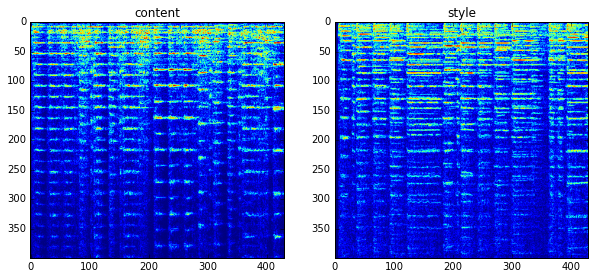

In [26]:
#compare spectrograms for content and style tracks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('content')
plt.imshow(a_content[0,:400,:])
plt.subplot(1, 2, 2)
plt.title('style')
plt.imshow(a_style[0,:400,:])
plt.show()

In [32]:
#during our tests, we discovered that it is essential to use extremely large number of conv filters 
#in this example we use single convolution with 4096 filters

N_FILTERS = 4096
inputs = InputLayer((1, N_CHANNELS, N_SAMPLES))
conv = ConvLayer(inputs, N_FILTERS, 11, W=lasagne.init.GlorotNormal(gain='relu'))

#implementation of losses and optimization is based on artistic style transfer example in lasagne recipes
#https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb
def gram_matrix(x):
    g = T.tensordot(x, x, axes=([2], [2])) / x.shape[2]
    return g

def style_loss(A, X,):
    G1 = gram_matrix(A)
    G2 = gram_matrix(X) 
    loss = ((G1 - G2)**2).sum()
    return loss

def content_loss(A, X):
    return ((A - X)**2).sum()

t = np.zeros_like(a_content)

content_features = lasagne.layers.get_output(conv, a_content)
style_features = lasagne.layers.get_output(conv, a_style)

generated = T.tensor3()
gen_features = lasagne.layers.get_output(conv, generated)

#set ALPHA=1e-3 for more style, or ALPHA=0 to turn off content entirely
ALPHA = 1e-2
loss = style_loss(style_features, gen_features) +\
            ALPHA * content_loss(content_features, gen_features)
grad = T.grad(loss, generated)

f_loss = theano.function([generated], loss)
f_grad = theano.function([generated], grad)

def eval_loss(x0):
    x0 = floatX(x0.reshape((1, N_CHANNELS, N_SAMPLES)))
    return f_loss(x0).astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, N_CHANNELS, N_SAMPLES)))
    return np.array(f_grad(x0)).flatten().astype('float64')

In [36]:
t = np.random.randn(1, N_CHANNELS, N_SAMPLES).astype(dtype=np.float32)

#optimization is done here
#res[1] is the loss, it should decrease
for i in range(10):
    res = scipy.optimize.fmin_l_bfgs_b(eval_loss, t.flatten(), fprime=eval_grad, maxfun=100)
    print i, res[1]

t = res[0].reshape((1, N_CHANNELS, N_SAMPLES))

0 613.461057408
1 570.166304581
2 564.513957354
3 562.560449891
4 561.699490257
5 561.226244923
6 560.898941615
7 560.645674613
8 560.464743678
9 560.349733334


In [68]:
a = np.zeros_like(a_content[0])
a[:N_CHANNELS,:] = np.exp(t[0]) - 1

#this code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(100):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x))

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [69]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

outputs/out.wav


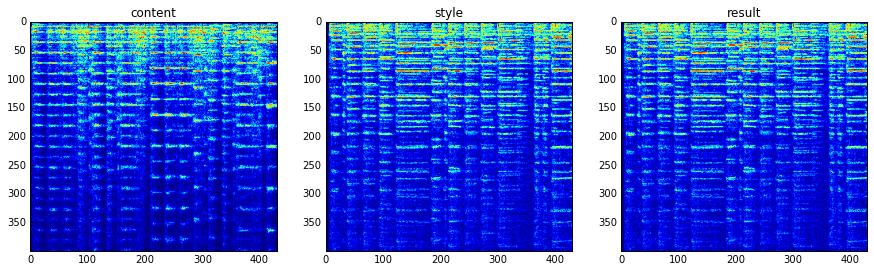

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('content')
plt.imshow(a_content[0,:400,:])
plt.subplot(1,3,2)
plt.title('style')
plt.imshow(a_style[0,:400,:])
plt.subplot(1,3,3)
plt.title('result')
plt.imshow(a_style[0,:400,:])
plt.show()